# 第三章 Tensor

几乎所有的深度学习框架背后的设计核心都是张量和计算图, PyTorch 也不例外, 本章我们将学习 PyTorch 中的张量系统(Tensor)和自动微分系统(autograd).

## 3.1 Tensor 基础

Tensor, 又名张量, 读者可能对这个名词似曾相识, 因为它不仅在 PyTorch 中出现过, 它也是 Theano、TensorFlow、Torch 和 MXNet 中重要的数据结构. 关于张量的本质不乏深度剖析的文章, 但从工程角度讲, 可简单地认为它就是一个数组, 且支持高效的科学计算. 它可以是一个数(标量)、一维数组(向量)、二维数组(矩阵)或更高维的数组(高阶数据). Tensor 和 Numpy 的 ndarrays 类似, 但前者支持 GPU 加速.

本节将系统讲解 Tensor 的使用, 力求面面俱到, 但不会涉及每个函数. 对于更多函数及其用法, 读者可通过在 IPython/Notebook 中使用函数名加 `?` 查看帮助文档, 或查阅 PyTorch 官方文档.

In [1]:
import torch as t

# 查看 PyTorch 的版本号
t.__version__

'2.4.1+cu121'

### 3.1.1 Tensor 的基本操作

学习过 NumPy 的读者会对本节内容感到非常熟悉, 因为 Tensor 的接口设计得与 Numpy 类似, 以方便用户使用. 当然, 若读者不熟悉 Numpy 也没关系, 本节内容并不要求读者事先掌握 Numpy.

从接口的角度来讲, 对 Tensor 的操作可分为两类:

1. `torch.function`, 如 `torch.save` 等.
2. `Tensor.function`, 如 `Tensor.view` 等.

为方便使用, 对 Tensor 的大部分操作同时支持这两类接口, 在本书中不做具体区分, 如 `torch.sum(a, b)` 与 `a.sum(b)` 功能等价.

而从存储的角度来讲, 对 Tensor的 操作又可分为两类:

1. 不会修改自身的数据, 如 `a.add(b)`, 加法的结果会返回一个新的 Tensor.
2. 会修改自身的数据, 如 `a.add_(b)`, 加法的结果仍存储在 a 中, a 被修改了.

函数名以 `_` 结尾的都是 inplace 方式, 即会修改调用者自己的数据, 在实际应用中需加以区分.

#### 创建 Tensor

在 PyTorch 中创建 Tensor 的方法有很多, 具体如表 3-1 所示:

表3-1: 常见创建 Tensor 的方法

|函数|功能|
|:---:|:---:|
|Tensor(\*sizes)|基础构造函数|
|tensor(data,)|类似np.array的构造函数|
|ones(\*sizes)|全1的Tensor|
|zeros(\*sizes)|全0的Tensor|
|eye(\*sizes)|对角线为1, 其他为0|
|arange(s,e,step)|从s到e, 步长为step|
|linspace(s,e,steps)|从s到e, 均匀切分成steps份|
|rand / randn(\*sizes)|均匀/标准分布|
|normal(mean,std) / uniform(from,to)|正态分布/均匀分布|
|randperm(m)|随机排列|
|tensor.new_\* / torch.\*_like | 创建一个相同size大小, 用*类型去填充(如tensor.new_ones就是使用全一的数据去填充)的张量, 具有相同的torch.dtype和torch.device|

这些创建方法都可以在创建的时候指定数据类型 dtype 和存放 device(CPU/GPU).

使用 `Tensor` 函数新建 Tensor 可以接收一个 list, 并根据 list 的数据新建 Tensor, 同时也能根据指定的形状新建 Tensor, 还能传入其他的 Tensor, 下面将举几个例子说明.


In [2]:
# 指定 Tensor 的形状
a = t.Tensor(2, 3)
a  # 数值取决于内存空间的状态, print 时候可能 overflow

tensor([[2.3533e+00, 4.3742e-41, 2.3533e+00],
        [4.3742e-41, 0.0000e+00, 0.0000e+00]])

In [3]:
# 用 list 的数据创建 Tensor
b = t.Tensor([[1, 2, 3], [4, 5, 6]])
b

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [4]:
b.tolist()  # 把 Tensor 转为 list

[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]

`tensor.size()` 返回 `torch.Size` 对象, 它是 tuple 的子类, 但其使用方式与 tuple 略有区别.

In [5]:
b_size = b.size()
b_size

torch.Size([2, 3])

In [6]:
# 统计 b 中元素总个数, 2*3, 两种方式等价
b.numel(), b.nelement()

(6, 6)

In [7]:
# 创建一个和 b 形状一样的 Tensor c
c = t.Tensor(b_size)

# 创建一个元素为 2 和 3 的 Tensor d
d = t.Tensor((2, 3))
c, d

(tensor([[-2.4697e-23,  3.1354e-41, -3.3753e+37],
         [ 4.3740e-41,  1.4013e-45,  0.0000e+00]]),
 tensor([2., 3.]))

需要注意的是, `t.Tensor(*sizes)` 创建 Tensor 时, 系统不会马上分配空间, 只是会计算剩余的内存是否足够使用, 在真正使用到 Tensor 时才会分配, 而其它操作都是在创建完 Tensor 之后马上进行空间分配. 在使用中, 我们更推荐使用 `torch.tensor` 而非 `torch.Tensor`. 接下来比较一下两者的区别.

`torch.Tensor` 是Python类, 并且默认是 torch.FloatTensor(), 运行 `torch.Tensor([2,3])` 会直接调用 Tensor 类的构造函数 `__init__()`, 生成结果是单精度浮点类型的 Tensor(FloatTensor).

而 `torch.tensor()` 是一个 Python 函数, 函数的原型为: `torch.tensor(data, dtype=None, device=None, requires_grad=False)`. 其中 `data` 支持 list、tuple、array、scalar 等类型, `torch.tensor()` 直接从 `data` 中做数据拷贝, 并根据原数据类型生成相应的 Tensor.

由于 `torch.tensor()` 能够根据数据类型生成对应的 Tensor, 因此在实际应用中我们更加推荐使用 `torch.tensor()` 方法来创建一个新的 Tensor. 下面将举例说明二者的不同之处.

In [8]:
# torch.Tensor 能直接创建空的张量
t.Tensor()

tensor([])

In [9]:
# torch.tensor 不能直接创建空的张量, 需要传入一个空的 data
# t.tensor()
# TypeError: tensor() missing 1 required positional arguments: "data"

t.tensor(())

tensor([])

In [10]:
a = t.tensor([2, 3])
print(a.type())
b = t.Tensor([2, 3])
print(b.type())

torch.LongTensor
torch.FloatTensor


In [11]:
import numpy as np

arr = np.ones((2, 3), dtype=np.float64)
a = t.tensor(arr)
a

tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

其它常用的创建 Tensor 方法举例如下.

In [12]:
# 创建一个形状是 (2, 3) 值全为 1 的 Tensor
t.ones(2, 3)

tensor([[1., 1., 1.],
        [1., 1., 1.]])

与 `torch.ones()` 类似的函数还有 `torch.ones_like(input)`, 输入 `input` 是一个 Tensor, 返回一个与之大小相同的全部填充为 1 的新 Tensor. 这意味着, `torch.ones_like(input)` 等价于 `torch.ones(input.size(), dtype=input.dtype, layout=input.layout, device=input.device)`.

In [13]:
input_tensor = t.tensor([[1, 2, 3], [4, 5, 6]])
t.ones_like(input_tensor)

tensor([[1, 1, 1],
        [1, 1, 1]])

In [14]:
# 创建一个形状是 (2, 3) 的全 0 的 Tensor
t.zeros(2, 3)

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [15]:
# 创建一个对角线为 1, 其余为 0 的 Tensor, 不要求行列数一致
t.eye(2, 3, dtype=t.int)

tensor([[1, 0, 0],
        [0, 1, 0]], dtype=torch.int32)

In [16]:
# 创建一个起始值为 1, 上限为 6, 步长为 2 的 Tensor
t.arange(1, 6, 2)

tensor([1, 3, 5])

In [17]:
# 创建一个均匀间距的 Tensor, 将 1 到 10 的数分为 3 份
t.linspace(1, 10, 3)

tensor([ 1.0000,  5.5000, 10.0000])

In [18]:
# 创建一个形状是 (2, 3) 的 Tensor, 其取值为从标准正态分布中抽取的随机数
t.randn(2, 3)

tensor([[ 1.6744,  1.7029,  0.1849],
        [-1.4183, -0.2134, -2.2111]])

In [19]:
# 创建一个长度为 5 的随机排列的 Tensor
t.randperm(5)

tensor([0, 3, 1, 4, 2])

In [20]:
# 创建一个大小为 (2, 3) 值全 1 的Tensor, 保留原始的 torch.dtype 和 torch.device
tensor3 = t.tensor((), dtype=t.int32)
tensor3.new_ones((2, 3))

tensor([[1, 1, 1],
        [1, 1, 1]], dtype=torch.int32)

#### 命名张量

命名张量(Named Tensors)旨在允许用户将显式名称与张量维度关联起来, 使张量更易于使用. 在大多数情况下, 使用维度名称来进行维度操作, 从而避免了按位置确定维度的需要. 此外, 命名张量使用名称来自动检查 API 是否在运行时正确使用, 从而提供额外的安全性. 名称还可用于重新排列维度, 例如, 支"按名称广播"而不是"按位置广播"等等. 现在允许张量拥有命名维度的工厂函数(factory functions)有: tensor, empty, ones, zeros, randn 等等.

下面将以深度学习中常用的维度来举例说明命名张量的使用, 其中 `N` 代表 batch_size, `C` 代表通道数, `H` 代表高度, `W` 代表宽度.

In [21]:
# 命名张量 API 在后续还有可能还有变化, 所以系统会提示 warning, 在此忽略
import warnings

warnings.filterwarnings("ignore")

# 直接使用 names 参数创建命名张量
imgs = t.randn(1, 2, 2, 3, names=("N", "C", "H", "W"))
imgs.names
imgs

tensor([[[[-0.6862,  0.6183,  1.2738],
          [ 1.0361, -1.1061,  1.2310]],

         [[ 0.1128,  1.8800, -0.7921],
          [ 1.9595,  1.6170, -0.7782]]]], names=('N', 'C', 'H', 'W'))

In [22]:
# 查看旋转操作造成的维度变换
imgs_rotate = imgs.transpose(2, 3)
imgs_rotate.names
imgs_rotate

tensor([[[[-0.6862,  1.0361],
          [ 0.6183, -1.1061],
          [ 1.2738,  1.2310]],

         [[ 0.1128,  1.9595],
          [ 1.8800,  1.6170],
          [-0.7921, -0.7782]]]], names=('N', 'C', 'W', 'H'))

In [23]:
# 通过 refine_names() 函数对未命名的张量命名, 其中不需要名字的可以用 None 表示
another_imgs = t.rand(1, 3, 2, 2)
another_imgs = another_imgs.refine_names("N", None, "H", "W")
another_imgs.names

('N', None, 'H', 'W')

In [24]:
# 修改部分维度的名称
renamed_imgs = imgs.rename(H="height", W="width")
renamed_imgs.names

('N', 'C', 'height', 'width')

In [25]:
# 通过维度的名称做维度转换
convert_imgs = renamed_imgs.align_to("N", "height", "width", "C")
convert_imgs.names

('N', 'height', 'width', 'C')

命名张量还可以直观的用于说明 Tensor 的形状改变和维度增减, 这一部分将在 3.2 节进行详细介绍.

#### Tensor 的类型

 Tensor 有不同的数据类型, 如表 3-2 所示, 每种类型分别对应有 CPU 和 GPU 版本(HalfTensor 除外). 默认的 Tensor 是 FloatTensor, 可通过 `torch.set_default_tensor_type` 来修改默认 Tensor 类型(如果默认类型为 GPU tensor, 则所有操作都将在 GPU 上进行). Tensor 的类型对分析内存占用很有帮助. 例如, 一个 size 为 (1000, 1000, 1000) 的 FloatTensor, 它有`1000*1000*1000=10^9` 个元素, 每个元素占 32bit/8 = 4Byte 内存, 所以共占大约 4GB 内存/显存.

 HalfTensor 是专门为 GPU 版本设计的, 同样的元素个数, 显存占用只有 FloatTensor 的一半, 所以可以极大缓解 GPU 显存不足的问题, 但由于 HalfTensor 所能表示的数值大小和精度有限, 所以可能出现溢出等问题.


表3-2: Tensor 数据类型

| Data type | dtype | CPU tensor   | GPU tensor   |
| ------------------------ | --------------------------------- | ----------------------------------------- | ------------------------- |
| 32-bit 浮点型   | `torch.float32` or `torch.float`  | `torch.FloatTensor`  | `torch.cuda.FloatTensor`  |
| 64-bit 浮点型   | `torch.float64` or `torch.double` | `torch.DoubleTensor` | `torch.cuda.DoubleTensor` |
| 16-bit 半精度浮点型    | `torch.float16` or `torch.half`  | `torch.HalfTensor`| `torch.cuda.HalfTensor`|
| 8-bit无符号整型 | `torch.uint8`  | `torch.ByteTensor`| `torch.cuda.ByteTensor`|
| 8-bit有符号整型  | `torch.int8`  | `torch.CharTensor`| `torch.cuda.CharTensor`|
| 16-bit有符号整型  | `torch.int16` or `torch.short`   | `torch.ShortTensor` | `torch.cuda.ShortTensor`  |
| 32-bit有符号整型 | `torch.int32` or `torch.int`  | `torch.IntTensor` | `torch.cuda.IntTensor` |
| 64-bit有符号整型  | `torch.int64` or `torch.long`  | `torch.LongTensor` | `torch.cuda.LongTensor`|


不同 Tensor 类型之间是可以互相转换的, 下面是常用的三种转换方法:

1. 各种数据类型之间可以互相转换, `type(new_type)` 是通用的做法, 同时还有 `float`、`long`、`half` 等快捷方法；
2. CPU Tensor 与 GPU Tensor之 间的互相转换通过 `tensor.cuda` 和 `tensor.cpu` 方法实现, 此外还可以使用` tensor.to(device)`
3. 创建同种类型的张量: `torch.*_like` 和 `tensor.new_*`. Tensor 还有一个 `new` 方法, 用法与 `torch.Tensor` 一样, 会调用该 Tensor 对应类型的构造函数, 生成与当前 Tensor 类型一致的 Tensor. 如 `torch.*_like(tensorA)` 可以生成和 `tensorA` 拥有同样属性(类型, 形状, CPU/GPU)的新 Tensor, 例如 `torch.ones_like()`, 而 `tensor.new_*(new_shape)` 可以新建一个不同形状的 Tensor, 例如 `tensor.new_zeros()`.

下面将举例说明 Tensor 之间的转换:

In [26]:
print(t.get_default_dtype())
# 更改默认 Tensor 的类型
a = t.rand(2, 3)
print(a.dtype)

# 设置默认类型为 DoubleTensor
t.set_default_dtype(t.float64)
a = t.rand(2, 3)
print(a.dtype)

# 恢复之前的默认设置
t.set_default_dtype(t.float32)
t.get_default_dtype()

torch.float32
torch.float32
torch.float64


torch.float32

In [27]:
print(t.get_default_dtype())
print(a.dtype)

# 通过 type 方法和快捷方法修改 Tensor 的类型
b1 = a.type(t.FloatTensor)
b2 = a.float()
a.dtype, b1.dtype, b2.dtype

torch.float32
torch.float64


(torch.float64, torch.float32, torch.float32)

In [28]:
# new 方法相当于利用 DoubleTensor 的构造函数, 因为此时 a 是 torch.float64 类型
# pytorch 2.4 的文档中没有找到 new 方法
a.new(2, 3)

tensor([[4.2522e+180, 7.4854e+247, 2.3236e+251],
        [6.1113e+223, 2.5990e-144, 1.9321e+184]], dtype=torch.float64)

#### 索引操作

Tensor 支持与 numpy.ndarray 类似的索引操作, 语法上也类似, 下面将通过一些例子讲解常用的索引操作. 其中, 能通过修改张量 stride/start/dim 等属性实现的索引操作与原 Tensor 共享内存, 也就是说如果修改其中一个, 另一个会跟着修改. 关于索引操作更详细的内容将在本书第六章中进行讲解.

In [29]:
a = t.randn(3, 4)
a

tensor([[ 0.1183, -0.1970, -1.1688, -0.8730],
        [ 0.7523,  0.7478, -0.6928, -1.6453],
        [-0.0370,  1.0595,  1.3300, -0.9504]])

In [30]:
print("查看第 1 行结果: ", a[0])
print("查看第 2 列结果: ", a[:, 1])
print("查看第 2 行最后两个元素: ", a[1, -2:])

查看第 1 行结果:  tensor([ 0.1183, -0.1970, -1.1688, -0.8730])
查看第 2 列结果:  tensor([-0.1970,  0.7478,  1.0595])
查看第 2 行最后两个元素:  tensor([-0.6928, -1.6453])


In [31]:
# 返回一个 ByteTensor
print(a > 0)  # bool 型
print((a > 0).int())  # 整型

tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [False,  True,  True, False]])
tensor([[1, 0, 0, 0],
        [1, 1, 0, 0],
        [0, 1, 1, 0]], dtype=torch.int32)


In [32]:
# 返回 Tensor 中满足条件的结果, 下面两种写法等价
# 选择返回的结果与原 Tensor 不共享内存空间
print(a[a > 0])
print(a.masked_select(a > 0))

# 用 torch.where 保留原始的索引位置, 不满足条件的位置置 0
print(t.where(a > 0, a, t.zeros_like(a)))

tensor([0.1183, 0.7523, 0.7478, 1.0595, 1.3300])
tensor([0.1183, 0.7523, 0.7478, 1.0595, 1.3300])
tensor([[0.1183, 0.0000, 0.0000, 0.0000],
        [0.7523, 0.7478, 0.0000, 0.0000],
        [0.0000, 1.0595, 1.3300, 0.0000]])


其它常用的选择函数如表 3-3 所示.

表 3-3 常用的选择函数

函数|功能|
:---:|:---:|
index_select(input, dim, index)|在指定维度dim上选取, 比如选取某些行、某些列
masked_select(input, mask)|例子如上, a[a>0], 使用ByteTensor进行选取
non_zero(input)|非0元素的下标
gather(input, dim, index)|根据index, 在dim维度上选取数据, 输出的size与index一样

`gather` 是一个比较复杂的操作, 对一个 2 维 Tensor, 输出的每个元素如下:

```python
out[i][j] = input[index[i][j]][j]  # dim=0
out[i][j] = input[i][index[i][j]]  # dim=1
```

In [33]:
a = t.arange(0, 16).view(4, 4)
a

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

In [34]:
# 选取对角线的元素
index = t.tensor([[0, 1, 2, 3]])
a.gather(0, index)

tensor([[ 0,  5, 10, 15]])

In [35]:
# 选取反对角线上的元素
index = t.tensor([[3, 2, 1, 0]]).t()
print(index)
a.gather(1, index)

tensor([[3],
        [2],
        [1],
        [0]])


tensor([[ 3],
        [ 6],
        [ 9],
        [12]])

In [36]:
# 选取两个对角线上的元素
index = t.tensor([[0, 1, 2, 3], [3, 2, 1, 0]]).t()
print(index)
b = a.gather(1, index)
b

tensor([[0, 3],
        [1, 2],
        [2, 1],
        [3, 0]])


tensor([[ 0,  3],
        [ 5,  6],
        [10,  9],
        [15, 12]])

与 `gather` 相对应的逆操作是 `scatter_`, `gather` 把数据从 input 中按 index 取出, 而 `scatter_` 是把取出的数据再放回去. 注意 `scatter_` 函数是 inplace 操作, 会直接对当前数据进行修改.

```python
out = input.gather(dim, index)
-->近似逆操作
out = Tensor()
out.scatter_(dim, index)
```

In [37]:
# 把两个对角线元素放回去到指定位置
c = t.zeros(4, 4).long()
print(c)
c.scatter_(1, index, b)

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])


tensor([[ 0,  0,  0,  3],
        [ 0,  5,  6,  0],
        [ 0,  9, 10,  0],
        [12,  0,  0, 15]])

对 Tensor 的任何索引操作得到的结果仍是一个 Tensor, 若想要获取标准的 Python 对象数值, 需要调用 `tensor.item()`, 需要注意的是这个方法只对包含一个元素的 Tensor 适用.

In [38]:
t.Tensor([1.0]).item()
# t.Tensor([1, 2]).item()
# raise ValueError: only one element tensors can be converted to Python scalars

1.0

#### 高级索引

目前的 PyTorch 已经支持绝大多数 NumPy 风格的高级索引. 高级索引可以看成是普通索引操作的扩展, 但是高级索引操作的结果一般不和原始的 Tensor 共享内存. 关于更多高级索引的内容可以参考本书第六章第三节.

In [39]:
x = t.arange(0, 16).view(2, 2, 4)
x

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[ 8,  9, 10, 11],
         [12, 13, 14, 15]]])

In [40]:
x[[1, 0], [1, 1], [2, 0]]  # x[1, 1, 2] 和 x[0, 1, 0]

tensor([14,  4])

In [41]:
x[[1, 0], [0], [1]]  # x[1, 0, 1], x[0, 0, 1]

tensor([9, 1])

#### 逐元素操作

逐元素操作会对 Tensor 的每一个元素(point-wise, 又名 element-wise)进行操作, 此类操作的输入与输出形状一致. 常用的操作如表 3-4 所示.

表3-4: 常见的逐元素操作

|函数|功能|
|:--:|:--:|
|abs/sqrt/div/exp/fmod/log/pow..|绝对值/平方根/除法/指数/求余/对数/求幂..|
|cos/sin/asin/atan2/cosh..|三角函数|
|ceil/round/floor/trunc| 上取整/四舍五入/下取整/只保留整数部分|
|clamp(input,min,max)|超过min和max部分截断|
|sigmod/tanh..|激活函数

对于很多操作, 例如 div、mul、pow、fmod 等, PyTorch 中都实现了运算符重载, 因此读者可以很方便的直接使用. 如 `a ** 2` 等价于 `torch.pow(a, 2)`, `a * 2` 等价于 `torch.mul(a, 2)`.

其中 `clamp(x, min, max)` 的输出满足以下公式:
$$
y_i =
\begin{cases}
min,  & \text{if  } x_i \lt min \\
x_i,  & \text{if  } min \le x_i \le max  \\
max,  & \text{if  } x_i \gt max\\
\end{cases}
$$

`clamp` 常用在某些需要比较大小的地方, 如取一个 Tensor 的每个元素与另一个数的较大值. 下面将举例说明一些常见的逐元素操作:

In [42]:
a = t.arange(0, 6).float().view(2, 3)
t.cos(a)

tensor([[ 1.0000,  0.5403, -0.4161],
        [-0.9900, -0.6536,  0.2837]])

In [43]:
# 取模运算的运算符重载, 二者等价
print(a % 3)
print(t.fmod(a, 3))

tensor([[0., 1., 2.],
        [0., 1., 2.]])
tensor([[0., 1., 2.],
        [0., 1., 2.]])


In [44]:
# 将 a 中的值进行上下限截断
print(a)
print(t.clamp(a, min=2, max=4))

tensor([[0., 1., 2.],
        [3., 4., 5.]])
tensor([[2., 2., 2.],
        [3., 4., 4.]])


#### 归并操作

归并操作会使用 Tensor 中的部分元素进行计算, 其输出形状可能小于输入形状. 同时我们可以沿着某一维度进行指定的归并操作. 如加法 `sum`, 既可以计算整个 Tensor 的和, 也可以计算 Tensor 中每一行或每一列的和. 常用的归并操作如表 3-5 所示.

表3-5: 常用归并操作

|函数|功能|
|:---:|:---:|
|mean/sum/median/mode|均值/求和/中位数/众数|
|norm/dist|范数/距离|
|std/var|标准差/方差|
|cumsum/cumprod|累加/累乘|

以上大多数函数都有一个维度参数 `dim`, 用来指定这些操作是在哪个维度上执行的. 关于 `dim` (对应于 Numpy 中的 axis)的解释众说纷纭, 这里提供一个简单的记忆方式:

假设输入的形状是(m, n, k)

- 如果指定 dim=0, 输出的形状就是 (1, n, k) 或者 (n, k)
- 如果指定 dim=1, 输出的形状就是 (m, 1, k) 或者 (m, k)
- 如果指定 dim=2, 输出的形状就是 (m, n, 1) 或者 (m, n)

其中 size 中是否有 "1", 取决于参数 `keepdim`, 若指定 `keepdim=True` 则会保留维度 `1`. 注意, 以上只是经验总结, 并非所有函数都符合这种形状变化方式, 如 `cumsum`. 下面将举例说明:

In [45]:
# 注意对比是否保留维度 1 的区别
b = t.ones(2, 3)
print(b)
print(b.sum(dim=0, keepdim=True), b.sum(dim=0, keepdim=True).shape)
print(b.sum(dim=0, keepdim=False), b.sum(dim=0, keepdim=False).shape)

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[2., 2., 2.]]) torch.Size([1, 3])
tensor([2., 2., 2.]) torch.Size([3])


In [46]:
a = t.arange(2, 8).view(2, 3)
print(a)
print(a.cumsum(dim=1))  # 沿着行累加

tensor([[2, 3, 4],
        [5, 6, 7]])
tensor([[ 2,  5,  9],
        [ 5, 11, 18]])


#### 比较

比较函数中有一些是逐元素比较, 操作类似于逐元素操作, 还有一些则类似于归并操作. 常用比较函数如表 3-6 所示.

表3-6: 常用比较函数

|函数|功能|
|:--:|:--:|
|gt/lt/ge/le/eq/ne|大于/小于/大于等于/小于等于/等于/不等于|
|topk|最大的k个数|
|sort|排序|
|max/min|比较两个Tensor的最大、最小值|

表中第一行的比较操作已经实现了运算符重载, 因此可以使用 `a>=b`、`a>b`、`a!=b`、`a==b`, 其返回结果是一个 `ByteTensor`, 可用来选取元素. max/min 这两个操作比较特殊, 以 max 来说, 它有以下三种使用情况:
- t.max(tensor): 返回 Tensor 中最大的一个数
- t.max(tensor,dim): 指定维上最大的数, 返回 Tensor 和下标
- t.max(tensor1, tensor2): 返回两个 Tensor 相比较大的元素

而若要比较一个 Tensor 和一个数, 可以使用 clamp 函数. 下面举例说明.

In [47]:
a = t.linspace(0, 15, 6).view(2, 3)
print(a)
b = t.linspace(15, 0, 6).view(2, 3)
print(b)
print(a > b)
print("a 中大于 b 的元素: ", a[a > b])  # 返回 a 中大于 b 的元素
print("a 中最大的元素: ", t.max(a))  # 返回 a 中最大的元素

tensor([[ 0.,  3.,  6.],
        [ 9., 12., 15.]])
tensor([[15., 12.,  9.],
        [ 6.,  3.,  0.]])
tensor([[False, False, False],
        [ True,  True,  True]])
a 中大于 b 的元素:  tensor([ 9., 12., 15.])
a 中最大的元素:  tensor(15.)


In [48]:
t.max(b, dim=1)
# 第一个返回值 15 和 6 分别表示第 0 行和第 1 行最大的元素
# 第二个返回值的 0 和 0 表示上述最大的数是该行第 0 个元素

torch.return_types.max(
values=tensor([15.,  6.]),
indices=tensor([0, 0]))

In [49]:
t.max(a, b)  # 两个 Tensor 对应位置上较大的元素

tensor([[15., 12.,  9.],
        [ 9., 12., 15.]])

#### 线性代数

PyTorch 的线性函数主要封装了 Blas 和 Lapack, 其用法和接口都与之类似. 常用的线性代数函数如表 3-7 所示.

表3-7: 常用的线性代数函数

|函数|功能|
|:---:|:---:|
|trace|对角线元素之和(矩阵的迹)|
|diag|对角线元素|
|triu/tril|矩阵的上三角/下三角, 可指定偏移量|
|mm/bmm|矩阵乘法, batch的矩阵乘法|
|addmm/addbmm/addmv|矩阵运算
|t|转置|
|dot/cross|内积/外积
|inverse|求逆矩阵
|svd|奇异值分解

具体使用说明请参见官方文档, 需要注意的是, 矩阵的转置会导致存储空间不连续, 因此需调用它的 `.contiguous` 方法将其转为连续. 下面将举例说明:


In [50]:
a = t.linspace(0, 15, 6).view(2, 3)
print(a)
print(a.is_contiguous())
b = a.t()
print(b)
b.is_contiguous()

tensor([[ 0.,  3.,  6.],
        [ 9., 12., 15.]])
True
tensor([[ 0.,  9.],
        [ 3., 12.],
        [ 6., 15.]])


False

In [51]:
b = b.contiguous()
b.is_contiguous()

True

### 3.1.2 Tensor 与 NumPy

Tensor 和 NumPy 数组之间具有很高的相似性, 彼此之间的互相操作也非常简单高效. 需要注意的是, NumPy 和 Tensor 共享内存. 由于 NumPy 中已经封装了很多常用操作, 所以当遇到 Tensor 不支持的操作时, 可先将其转换成 NumPy 数组, 进行相应处理后再转回 Tensor. 由于这样操作的转换开销很小, 因此在实际应用中我们将经常进行两者的相互转换, 下面将举例说明.

In [52]:
import numpy as np

a = np.ones([2, 3], dtype=np.float32)
a

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [53]:
# 从 NumPy 转化为 Tensor, 下面两种方式等价
b = t.from_numpy(a)

# 注意此时是大写的 Tensor, torch.tensor() 只进行数据拷贝, 不会共享内存.
# b = t.Tensor(a)

b

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [54]:
# 此时, NumPy 和 Tensor 是共享内存的
a[0, 1] = -1
b  # 修改 a 的值, b 的值也会被修改

tensor([[ 1., -1.,  1.],
        [ 1.,  1.,  1.]])

**注意**:  当 NumPy 的数据类型和T ensor 的类型不一样的时候, 数据会被复制, 不会共享内存.

In [55]:
a = np.ones([2, 3])
# 注意和上面的 a 的区别(dtype 不是 float32)
a.dtype

dtype('float64')

In [56]:
b = t.Tensor(a)  # 此处进行拷贝, 不共享内存
b.dtype

torch.float32

In [57]:
c = t.from_numpy(a)  # 注意 c 的类型(DoubleTensor)
c

tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

In [58]:
a[0, 1] = -1
print(b)  # b 与 a 不共享内存, 所以即使 a 改变了, b 也不变
print(c)  # c 与 a 共享内存

tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[ 1., -1.,  1.],
        [ 1.,  1.,  1.]], dtype=torch.float64)


**注意:** 不论输入的类型是什么, torch.tensor() 都只进行进行数据拷贝, 不会共享内存. 读者需要注意区分 torch.Tensor(), torch.from_numpy() 与 torch.tensor() 在内存共享方面的区别.

In [59]:
a_tensor = t.tensor(a)
a_tensor[0, 1] = 1
a  # a 和 a_tensor 不共享内存

array([[ 1., -1.,  1.],
       [ 1.,  1.,  1.]])

### 3.1.3 Tensor 的基本结构

Tensor 的数据结构如图 3-1 所示. Tensor 分为头信息区(Tensor)和存储区(Storage), 头信息区主要保存着 Tensor 的形状(size)、步长(stride)、数据类型(type)等信息, 而真正的数据则保存成连续数组. 由于数据动辄成千上万, 因此头信息区元素占用内存较少, 主要内存占用取决于 Tensor 中元素的数目, 也即存储区的大小.

一般来说一个 Tensor 有与之对应的 Storage, Storage 是在 data 之上封装的接口, 便于使用, 而 Tensor 的内存地址是指向 Tensor的头(head). 不同 Tensor 的 head 信息一般不同, 但却可能使用相同的 Storage. 很多关于 Tensor 的操作只是创建了一个新的 head, 但是它们仍共享同一个 Storage, 下面将举例说明.

![图3-1: Tensor的数据结构](imgs/tensor_data_structure.png)

In [60]:
a = t.arange(0, 10).float()
b = a.view(2, 5)
print(a.storage())
print(b.storage())

# id(变量) 可以查看它在内存中的地址
# Storage 的内存地址一样, 即它们是同一个 Storage
id(b.storage()) == id(a.storage())  # 应该输出 True, 之所以输出 False 可能和运行环境有关

 0.0
 1.0
 2.0
 3.0
 4.0
 5.0
 6.0
 7.0
 8.0
 9.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 10]
 0.0
 1.0
 2.0
 3.0
 4.0
 5.0
 6.0
 7.0
 8.0
 9.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 10]


False

In [61]:
# a 改变, b 也随之改变, 因为他们共享 Storage
a[1] = 100
b

tensor([[  0., 100.,   2.,   3.,   4.],
        [  5.,   6.,   7.,   8.,   9.]])

In [62]:
# c 取得 a 的部分索引, 只改变了 head 信息, Storage 相同
c = a[3:]
id(c.storage()) == id(a.storage())  # 应该输出 True, 之所以输出 False 可能和运行环境有关

False

In [63]:
# data_ptr 返回 Tensor 首元素的内存地址
c.data_ptr(), a.data_ptr()
# 可以看出两个内存地址相差 12, 这是因为 3*4=12: 相差三个元素, 每个元素占 4 个字节(float)
# 如果差值不是 12, 可以用 a.type() 查看一下数据类型是不是 torch.FloatTensor

(96102498545420, 96102498545408)

In [64]:
c[0] = -100  # c[0] 的内存地址对应 a[3] 的内存地址
a

tensor([   0.,  100.,    2., -100.,    4.,    5.,    6.,    7.,    8.,    9.])

In [65]:
d = t.Tensor(c.storage())  # 此处拷贝共享了内存
d[0] = 6666
b

tensor([[ 6.6660e+03,  1.0000e+02,  2.0000e+00, -1.0000e+02,  4.0000e+00],
        [ 5.0000e+00,  6.0000e+00,  7.0000e+00,  8.0000e+00,  9.0000e+00]])

In [66]:
# 下面 ４ 个 Tensor 共享 Storage
id(a.storage()) == id(b.storage()) == id(c.storage()) == id(
    d.storage()
)  # 应该输出 True, 之所以输出 False 可能和运行环境有关

True

In [67]:
# c 取得 a 的部分索引, 改变了偏移量

a.storage_offset(), c.storage_offset(), d.storage_offset()

(0, 3, 0)

In [68]:
e = b[::2, ::2]  # 隔 2 行/列取一个元素
print(id(e.storage()) == id(a.storage()))  # 共享内存
print(e.is_contiguous())  # e 的存储空间是不连续的

False
False


可见绝大多数操作并不修改 Tensor 的数据, 而只是修改了 Tensor 的头信息. 这种做法更节省内存, 同时提升了处理速度. 在使用中需要注意: 有些操作会导致 Tensor 不连续, 这时需要调用 `tensor.contiguous` 方法将它们变成连续的数据, 该方法会使数据复制一份, 不再与原来的数据共享 Storage.
另外读者可以思考一下, 之前说过的高级索引一般不共享 Storage, 而普通索引则共享 Storage, 这是为什么？(提示: 普通索引可以通过修改 Tensor 的 offset、stride 和 size 实现, 不修改Storage 的数据, 高级索引则不行).

## 3.2 变形记: N 种改变 Tensor 形状的方法

Tensor 作为 PyTorch 的基本数据对象, 使用过程中常需要改变 Tensor 的形状. 在 PyTorch 中有很多用于改变形状的函数, 在这一小节中我们将详细介绍一些常用的方法.

本小节介绍的所有函数都可以用 `tensor.shape` 和 `tensor.reshape(*new_shape)` 来实现, 这里笔者将对常见的 Tensor 形状相关的操作进行总结, 以方便读者选择最灵活便捷的函数.

### 查看 Tensor 的维度

关于 Tensor 的形状信息, 除了 `tensor.shape`, 还有以下三个常用函数:
- `tensor.size()` 等价于 `tensor.shape`
- `tensor.dim()` 能查看 Tensor 的维度, 等效于 `len(tensor.shape)`, 对应于 NumPy 中的 `array.ndim`
- `tensor.numel()` 用来查看 tensor 中元素的数量, 等价于 `tensor.shape[0]*tensor.shape[1]*...` 或者 `np.prod(tensor.shape)`, 对应于 NumPy 中的 `array.size`.

In [69]:
import torch as t

tensor = t.arange(24).reshape(2, 3, 4)
# tensor.shape 和tensor.size() 等价

print(f"a.shape={tensor.shape}. a.size()={tensor.size()}")

a.shape=torch.Size([2, 3, 4]). a.size()=torch.Size([2, 3, 4])


In [70]:
f"这是个 {tensor.dim()} 维 Tensor, 总共 {tensor.numel()} 个元素"

'这是个 3 维 Tensor, 总共 24 个元素'

### 改变 Tensor 的维度

所有改变 Tensor 形状的操作都可以通过 `tensor.reshape` 实现. `tensor.reshape(new_shape)` 会把不连续的 Tensor 变成连续的再进行形状变化, 这一操作等价于 `tensor.contiguous().view(new_shape)`. 关于 `view` 和 `reshape` 的选用可参考下面的建议:

1. 对于 `reshape` 而言: 其接口更便捷, 会自动把不连续的 Tensor 变为连续的, 能避免很多报错. 同时它的函数名和 NumPy 一样, 便于使用.
2. 对于 `view` 而言: 其函数名更短, 而且 Tensor 经过 `view` 操作之后仍然共享存储空间. 当我们并不希望改变形状之后的 Tensor 和原 Tensor 共享存储时可以使用 `view` 方法.

`reshape` 和 `view` 二者之间有一些区别: 如果对 Tensor 使用了 `transpose`、`permute` 等操作, 会造成 Tensor 的内存变得不连续, 而 `view` 方法只能改变连续的张量, 所以需要先调用 `contiguous()` 方法, 但 `reshape` 方法则不受此限制. 具体来说, `view` 方法返回的 Tensor 和原 Tensor 共享 Storage(注意: 不是共享内存地址), 而 `reshape` 方法可能返回原 Tensor 的 copy 或者共享 Storage 的 view. 如果当前满足连续性条件, 则结果与 `view` 相同; 否则返回的就是 copy(此时等价于 `tensor.contiguous().view()`).

In [71]:
a = t.arange(1, 13)
b = a.view(2, 6)
c = a.reshape(2, 6)  # 此时 view 和 reshape 等价, 因为 Tensor 是 contiguous
# a,b,c 三个对象的内存地址是不一样的, 其中保存的是 Tensor 的形状(size)、步长(stride)、数据类型(type)等信息

id(a) == id(b) == id(c)

False

In [72]:
# view 和 reshape 存储在与原始对象不同的地址内存中, 但是它们共享存储器 Storage, 也就意味着它们共享基础数据

id(a.storage()) == id(b.storage()) == id(c.storage())

False

In [73]:
b = b.t()  # b 不再连续
b.reshape(-1, 4)  # reshape 可以

# 下面会报错, view 无法在改变数据存储的情况下进行形状变化
# b.view(-1, 4)

tensor([[ 1,  7,  2,  8],
        [ 3,  9,  4, 10],
        [ 5, 11,  6, 12]])

reshape 操作的难点在于如何快速灵活地指定形状, 常用的快捷变形方法有:

1. `tensor.view(dim1,-1,dimN)`: 在调整 Tensor 形状的时候, 我们不需要指定每一维的形状, 可以把其中一个维度指定为 -1, PyTorch 会自动计算对应的形状
2. `tensor.view_as(other)`: 将 Tensor 的形状变为和 other 一样, 等价于 `tensor.view(other.shape)`
3. `tensor.squeeze()`: 将 Tensor 形状中为`1`的维度去掉, 比如 (1,3,1,4) 变为 (3,4)
4. `tensor.flatten(start_dim=0, end_dim=-1)`: 将 Tensor 形状中某些连续维度合并为一个维度. 比如形状 (2,3,4,5) -> (2,12,5).
5. `tensor[None]` 和 `tensor.unsqueeze(dim)`: 为 Tensor 新建一个维度, 并把形状设为 1, 比如形状 (2,3) -> (2,1,3)

In [74]:
# 创建一张噪声图像, 并计算 RGB 每一个通道的噪声均值
img_3xHxW = t.randn(3, 128, 256)

# 将 img_3xHxW 的后两维合并
img_3xHW = img_3xHxW.view(3, -1)
# 写法等价于 img_3xHxW.view(3,128*256)
# 也等价于 img_3xHxW.flatten(1, 2)

img_3xHW.mean(dim=1)

tensor([-0.0062,  0.0094,  0.0053])

In [75]:
# 图片除了 RGB 通道, 还可以有 alpha 通道用来表示透明度

alpha_HxW = t.rand(128, 256)
alpha_1xHxW = alpha_HxW[None]  # 等价于 alpha.unsqueeze(0)
rgba_img = t.cat([alpha_1xHxW, img_3xHxW], dim=0)
rgba_img.shape

torch.Size([4, 128, 256])

In [76]:
# 去掉第一维的 1
# 也可以使用 alpha_1xHxW.squeeze(): 去掉所有为 1 的维度
# 也可以使用 alpha_1xHxW.flatten(0, 1): 1 和 128 合并
# 也可以使用 alpha_1xHxW[0]: 通过索引取出第一维的数据

alpha_HxW = alpha_1xHxW.view(128, 256)

### 转置 `torch.transpose/tensor.permute`

注意, Tensor 的转置(transpose)和改变形状(reshape)是两个不一样的概念. 比如将一张图片旋转 90 度, 就属于向量的转置, 无法通过单纯的改变向量形状实现.

`transpose` 和 `permute` 函数都可以用于高维矩阵的转置, 但用法上稍有区别: `transpose`只能用于两个维度的转置, 意思就是只能改变两个维度的信息, 而 `permute` 可以对任意高维矩阵进行转置, 直接输入转置后维度 index 即可. 我们可以通过多次 `transpose` 变换达到和 `permute` 相同的效果. 常用的转置操作还有 `tensor.t()` 和 `tensor.T`, 它们和 `tensor.transpose()`一样都属于 `permute` 的特例.

另外, 向量的转置操作大多数情况下和输入的 Tensor 共享存储, 但是会使得向量变得不连续, 此时最好通过 `tensor.contiguous()` 将它变成连续. 但是有些操作(比如 `tensor.sum/max`)支持不连续的 Tensor, 那么你可以不用将它变成连续, 这样可以节省内存/显存.

In [77]:
mask = t.arange(6).view(2, 3)  # 一张高为2, 宽为3的图片
mask

tensor([[0, 1, 2],
        [3, 4, 5]])

In [78]:
# 将图片旋转 90 度, 也就是第一个维度(0)和第二个维度交换
# 等价于 mask.transpose(1,0)
# 等价于 mask.t() 或 img.T
# 等价于 mask.permute(1, 0), 不等价于 img.permute(0, 1)

mask.transpose(0, 1)

tensor([[0, 3],
        [1, 4],
        [2, 5]])

In [79]:
# 单纯地改变图片的形状
# 注意和上面的区别, 结果仍然是连续的

mask.view(3, 2)

tensor([[0, 1],
        [2, 3],
        [4, 5]])

In [80]:
# PyTorch 等深度学习框架中图片一般存储为 3xHxW

img_3xHxW = t.randn(3, 128, 256)

# 而在OpenCV/NumPy/skimage 中, 图片一般存储为 HxWx3
# img_3xHxW 的形状为 shape=[3,H,W], 经过 permute(1,2,0) 得到的形状为:
# [shape[1], shape[2], shape[0]] = [H, W, 3]

img_HxWx3 = img_3xHxW.permute(1, 2, 0)

img_HxWx3.is_contiguous()

False

In [81]:
img_HxWx3.reshape(-1)  # .view 会报错, 因为img_HxWx3不连续

tensor([ 1.3911,  0.0611, -0.5226,  ..., -0.3549,  0.6230, -0.2300])

一个用来区分什么时候用 `tensor.reshape` 还是 `tensor.transpose` 的小技巧: 如果输出 Tensor 的数据排列和输入一样就是用 `tensor.reshape`, 否则应该使用 `tensor.transpose`.

In [82]:
H, W = 4, 5
img_3xHxW = t.randn(3, H, W)

# 目标数据排列和输入一样, 直接使用 reshape
img_3xHW = img_3xHxW.reshape(3, -1)

# 目标数据排列和输入不一样, 先通过 transpose 变成 (3, W, H), 再变成 (3, WH)
img_3xWH = img_3xHxW.transpose(1, 2).reshape(3, -1)

# 再变形为 3xWxH 的形式
img_3xWxH = img_3xWH.reshape(3, W, H)

## 3.3 小试牛刀: 线性回归

线性回归是机器学习的入门知识, 应用十分广泛. 线性回归利用数理统计中的回归分析来确定两种或两种以上变量间相互依赖的定量关系, 其表达形式为 $y = wx+b+e$, 误差 $e$ 服从均值为 0 的正态分布. 线性回归的损失函数是:
$$
loss = \sum_i^N \frac 1 2 ({y_i-(wx_i+b)})^2
$$
我们可以利用随机梯度下降法更新参数 $\textbf{w}$和$\textbf{b}$ 来最小化损失函数, 最终学得 $\textbf{w}$ 和 $\textbf{b}$ 的数值.

In [83]:
import torch as t

%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

device = t.device("cpu")  # 如果你想用 GPU, 改成 t.device('cuda:0')

In [84]:
# 设置随机数种子, 保证在不同电脑上运行时下面的输出一致

t.manual_seed(1000)


def get_fake_data(batch_size=8):
    """产生随机数据: y=x*2+3, 加上了一些噪声"""
    x = t.rand(batch_size, 1, device=device) * 5
    y = x * 2 + 3 + t.randn(batch_size, 1, device=device)
    return x, y

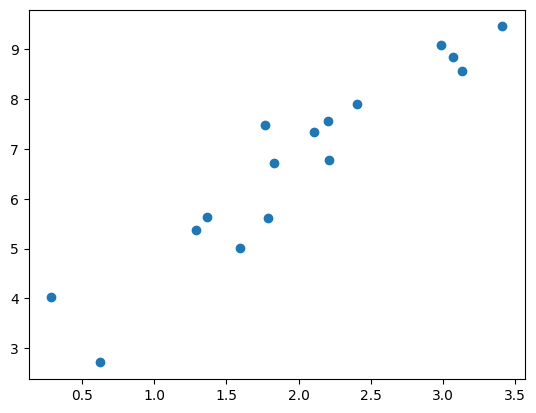

In [85]:
# 来看看产生的 x-y 分布

x, y = get_fake_data(batch_size=16)
plt.scatter(x.squeeze().cpu().numpy(), y.squeeze().cpu().numpy())

torch.FloatTensor torch.FloatTensor


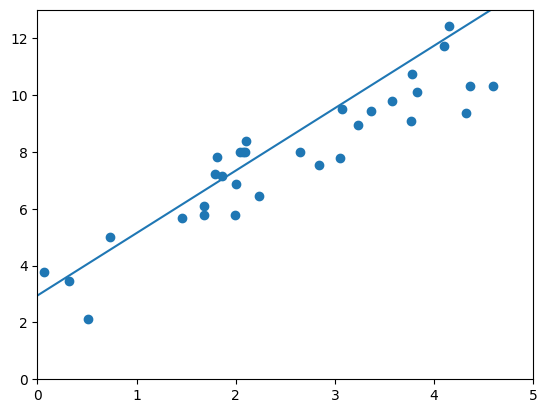

w:  1.9115010499954224 b:  3.044184446334839


In [86]:
# 随机初始化参数

w = t.rand(1, 1).to(device)
b = t.zeros(1, 1).to(device)

lr = 0.02  # 学习率 learning rate

for ii in range(500):
    x, y = get_fake_data(batch_size=4)

    # forward: 计算 loss

    y_pred = x.mm(w) + b.expand_as(y)  # expand_as 用到了广播法则, 将在第六章详析介绍
    loss = 0.5 * (y_pred - y) ** 2  # 均方误差
    loss = loss.mean()

    # backward: 手动计算梯度

    dloss = 1
    dy_pred = dloss * (y_pred - y)

    dw = x.t().mm(dy_pred)
    db = dy_pred.sum()

    # 更新参数

    w.sub_(lr * dw)  # inplace 修改
    b.sub_(lr * db)

    if ii % 50 == 0:
        # 画图

        display.clear_output(wait=True)
        x = t.arange(0, 6).float().view(-1, 1)
        print(x.type(), w.type())
        y = x.mm(w) + b.expand_as(x)
        plt.plot(x.cpu().numpy(), y.cpu().numpy())  # predicted

        x2, y2 = get_fake_data(batch_size=32)
        plt.scatter(x2.numpy(), y2.numpy())  # true data

        plt.xlim(0, 5)
        plt.ylim(0, 13)
        plt.show()
        plt.pause(0.5)
print("w: ", w.item(), "b: ", b.item())

可见程序已经基本学出 w=2、b=3, 并且图中直线和数据已经实现较好的拟合.

## 3.4 autograd 和计算图基础

在训练网络时使用 Tensor 非常方便, 但从 3.3 节线性回归的例子来看, 反向传播过程需要手动实现. 这对于像线性回归等较为简单的模型, 还比较容易, 但在实际使用中经常出现非常复杂的网络结构, 此时如果手动实现反向传播, 不仅费时费力, 而且容易出错, 难以检查. `torch.autograd` 就是为了方便用户使用, 而专门开发的一套自动求导引擎, 它能够根据输入和前向传播过程自动构建计算图, 并执行反向传播.

计算图(Computation Graph)是包括 PyTorch 和 TensorFlow 在内的许多现代深度学习框架的核心, 它为自动求导算法——反向传播(Back Propogation)提供了计算基础, 了解计算图在实际写程序过程中会有极大的帮助. 本节将涉及一些基础的计算图知识, 但并不要求读者事先对此有深入的了解.

### 3.4.1 requires_grad

PyTorch 在 autograd 模块中实现了计算图的相关功能, autograd 中的核心数据结构便是 Tensor. 当用户定义网络模型时, autograd 会记录与网络相关的 Tensor 的所有操作, 从而形成一个前向传播的有向无环图(DAG). 在这个图中, 输入网络的 Tensor 会成为叶子节点, 而网络输出的 Tensor 会成为根节点, autograd 便可从根节点开始遍历, 并对其中所有 `requires_grad=True` 的 Tensor 进行求导操作, 这样逐层遍历至叶子节点时, 便可通过链式操作计算梯度, 从而自动完成了反向传播操作. autograd 中核心的反向传播函数如下:

`torch.autograd.backward(tensors, grad_tensors=None, retain_graph=None, create_graph=False)`

其中:
- tensors: 用于计算梯度的 Tensor, 如 torch.autograd.backward(y)(等价于y.backward())
- grad_tensors: 形状与 Tensor 一致, 对于 `y.backward()`, grad_variables 相当于链式法则 ${dz \over dx}={dz \over dy} \times {dy \over dx}$ 中的 $\textbf {dz} \over \textbf {dy}$. grad_variables 也可以是 tensor 或序列.
- retain_graph: 反向传播需要缓存一些中间结果, 反向传播之后, 这些缓存就被清空, 可通过指定这个参数不清空缓存, 用来多次反向传播.
- create_graph: 对反向传播过程再次构建计算图, 可通过 `backward of backward` 实现求高阶导数.

下面举几个简单的例子来说明autograd如何使用.

In [87]:
from __future__ import print_function
import torch as t

# 下面两种写法等价
a = t.randn(3, 4, requires_grad=True)
# a = t.randn(3, 4).requires_grad_()

a.requires_grad

True

In [88]:
# 也可以单独设置 requires_grad

a = t.randn(3, 4)
a.requires_grad = True

In [89]:
b = t.zeros(3, 4).requires_grad_()
c = (a + b).sum()
c.backward()
c

tensor(-1.6152, grad_fn=<SumBackward0>)

In [90]:
a.grad

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [91]:
# 此处虽然没有指定 c 需要求导, 但 c 依赖于 a, 而 a 需要求导,
# 因此 c 的 requires_grad 属性会自动设为 True

a.requires_grad, b.requires_grad, c.requires_grad

(True, True, True)

#### Tensor 的 is_leaf 属性

对于计算图中的 Tensor 而言, 只有当 `is_leaf=True` 时, 其导数结果才会被保留下来, 我们称这样的 Tensor 为 Leaf Tensor, 也就是计算图中的叶子节点. 设计 Leaf Tensor 的初衷是为了节省内存/显存, 因为通常情况下我们不会直接使用非叶子节点的梯度信息. 下面给出 Leaf Tensor 的判断准则:

- 当 Tensor 的 requires_grad 为 False 的时候, 它就是 Leaf Tensor
- 当 Tensor 的 requires_grad 为 True, 但是是由用户创建的时候, 它也是 Leaf Tensor.

需要注意的是, Leaf Tensor 的 grad_fn 属性为 None. 下面将举例说明 Leaf Tensor 的判断准则.

In [92]:
a.is_leaf, b.is_leaf, c.is_leaf

(True, True, False)

In [93]:
a = t.rand(10, requires_grad=True)
a.is_leaf

True

In [94]:
b = t.rand(10, requires_grad=True)
b.is_leaf

True

In [95]:
c = t.rand(10, requires_grad=True) + 2
c.is_leaf

False

In [96]:
d = t.rand(10)
print(d.requires_grad)  # False
print(d.is_leaf)  # 除了创建外没有其他操作(由 autograd 实现的)

False
True


In [97]:
e = t.rand(10).requires_grad_()
e.is_leaf  # 同样的, 在创建 e 的时候没有额外的操作

True

接着我们来看看 autograd 计算的导数和我们手动推导的导数的区别:

$$
y = x^2\bullet e^x
$$

它的导函数是:

$$
{dy \over dx} = 2x\bullet e^x + x^2 \bullet e^x
$$

In [98]:
def f(x):
    """计算y"""
    y = x**2 * t.exp(x)
    return y


def gradf(x):
    """手动求导函数"""
    dx = 2 * x * t.exp(x) + x**2 * t.exp(x)
    return dx

In [99]:
x = t.randn(3, 4, requires_grad=True)
y = f(x)
y

tensor([[0.0109, 0.2316, 0.8111, 7.1278],
        [0.4126, 0.5035, 0.5146, 0.9632],
        [0.5159, 1.0523, 0.0118, 0.3755]], grad_fn=<MulBackward0>)

In [100]:
y.backward(t.ones(y.size()))  # gradient 形状与 y 一致
x.grad

tensor([[ 0.2308, -0.4555,  3.3047, 17.6441],
        [-0.3174, -0.1639, -0.1357,  3.7401],
        [-0.1319,  3.9884,  0.2404, -0.3601]])

In [101]:
# autograd 的计算结果与利用公式手动计算的结果一致

gradf(x)

tensor([[ 0.2308, -0.4555,  3.3047, 17.6441],
        [-0.3174, -0.1639, -0.1357,  3.7401],
        [-0.1319,  3.9884,  0.2404, -0.3601]], grad_fn=<AddBackward0>)

### 3.4.2 计算图

PyTorch中 `autograd` 的底层采用了计算图, 计算图是一种特殊的有向无环图(DAG), 用于记录算子与变量之间的关系. 一般用矩形表示算子, 椭圆形表示变量. 如表达式 $ \textbf {z = wx + b}$ 可分解为 $\textbf{y = wx}$和$\textbf{z = y + b}$, 其计算图如图 3-2 所示, 图中 `MUL`, `ADD` 都是算子, $\textbf{w}$, $\textbf{x}$, $\textbf{b}$ 即变量.

![图3-2:computation graph](imgs/com_graph.png)

如上有向无环图中, $\textbf{X}$ 和 $\textbf{b}$ 是叶子节点, 这些节点通常由用户自己创建, 不依赖于其他变量. $\textbf{z}$ 称为根节点, 是计算图的最终目标. 利用链式法则很容易求得各个叶子节点的梯度.

$${\partial z \over \partial b} = 1,\space {\partial z \over \partial y} = 1\\
{\partial y \over \partial w }= x,{\partial y \over \partial x}= w\\
{\partial z \over \partial x}= {\partial z \over \partial y} {\partial y \over \partial x}=1 * w\\
{\partial z \over \partial w}= {\partial z \over \partial y} {\partial y \over \partial w}=1 * x\\
$$

而有了计算图, 上述链式求导即可利用计算图的反向传播自动完成, 其过程如图 3-3 所示.

![图3-3: 计算图的反向传播](imgs/com_graph_backward.png)

在 PyTorch 实现中, autograd 会随着用户的操作, 记录生成当前 Tensor 的所有操作, 并由此建立一个有向无环图. 用户每进行一个操作, 相应的计算图就会发生改变. 更底层的实现中, 图中记录了操作 `Function`, 每一个变量在图中的位置可通过其 `grad_fn` 属性在图中的位置推测得到. 在反向传播过程中, autograd 沿着这个图从当前变量(根节点 $\textbf{z}$)溯源, 可以利用链式求导法则计算所有叶子节点的梯度. 每一个前向传播操作的函数都有与之对应的反向传播函数用来计算输入的各个 Tensor 的梯度, 这些函数的函数名通常以 `Backward` 结尾. 下面结合代码学习 autograd 的实现细节.

In [102]:
x = t.ones(1)
b = t.rand(1, requires_grad=True)
w = t.rand(1, requires_grad=True)
y = w * x  # 等价于 y = w.mul(x)
z = y + b  # 等价于 z = y.add(b)

x.requires_grad, b.requires_grad, w.requires_grad

(False, True, True)

In [103]:
# 虽然未指定 y.requires_grad 为 True, 但由于 y 依赖于需要求导的 w
# 故而 y.requires_grad 为 True

y.requires_grad

True

In [104]:
# grad_fn 可以查看这个 Tensor 的反向传播函数,
# z 是 add 函数的输出, 所以它的反向传播函数是 AddBackward

z.grad_fn

In [105]:
# next_functions 保存 grad_fn 的输入, 是一个 tuple, tuple 的元素也是 Function
# 第一个是 y, 它是乘法(mul)的输出, 所以对应的反向传播函数 y.grad_fn 是 MulBackward
# 第二个是 b, 它是叶子节点, 由用户创建, grad_fn 为 None, 但是有

z.grad_fn.next_functions

((<MulBackward0 at 0x79eefc624130>, 0),
 (<AccumulateGrad at 0x79eefc6242e0>, 0))

In [106]:
# 第一个是 w, 叶子节点, 需要求导, 梯度是累加的
# 第二个是 x, 叶子节点, 不需要求导, 所以为 None

y.grad_fn.next_functions

((<AccumulateGrad at 0x79eefc6245b0>, 0), (None, 0))

In [107]:
# 叶子节点的 grad_fn 是 None

w.grad_fn, x.grad_fn

(None, None)

计算 w 的梯度的时候, 需要用到 x 的数值(${\partial y\over \partial w} = x $), 这些数值在前向过程中会保存成 buffer, 在计算完梯度之后会自动清空. 为了能够多次反向传播需要指定 `retain_graph` 来保留这些 buffer.

In [108]:
# 使用 retain_graph 来保存 buffer

z.backward(retain_graph=True)
w.grad

tensor([1.])

In [109]:
# 多次反向传播, 梯度累加, 这也就是 w 中 AccumulateGrad 标识的含义
z.backward()
w.grad

tensor([2.])

PyTorch 使用的是动态图, 它的计算图在每次前向传播时都是从头开始构建, 所以它能够使用 Python 控制语句(如 for、if 等)根据需求创建计算图. 这点在自然语言处理领域中很有用, 它意味着你不需要事先构建所有可能用到的图的路径, 图在运行时才构建.

In [110]:
def abs(x):
    if x.data[0] > 0:
        return x
    else:
        return -x


x = t.ones(1, requires_grad=True)
y = abs(x)
y.backward()
x.grad

tensor([1.])

In [111]:
def f(x):
    result = 1
    for ii in x:
        if ii.item() > 0:
            result = ii * result
    return result


x = t.arange(-2, 4).float().requires_grad_()
y = f(x)  # y = x[3]*x[4]*x[5]
y.backward()
x.grad

tensor([0., 0., 0., 6., 3., 2.])

变量的 `requires_grad` 属性默认为False, 如果某一个节点 `requires_grad` 被设置为 True, 那么所有依赖它的节点 `requires_grad` 都是 True. 这其实很好理解, 对于 $ \textbf{x}\to \textbf{y} \to \textbf{z}$, x.requires_grad = True, 当需要计算 $\partial z \over \partial x$ 时, 根据链式法则, $\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}$, 自然也需要求 $ \frac{\partial z}{\partial y}$, 所以 `y.requires_grad` 会被自动标为 True.

有些时候我们可能不希望 autograd 对 Tensor 求导. 认为求导需要缓存许多中间结构, 增加额外的内存/显存开销, 那么我们可以关闭自动求导. 对于不需要反向传播的情景(如 inference, 即测试推理时), 关闭自动求导可实现一定程度的速度提升, 并节省约一半显存, 因其不需要分配空间计算梯度.

In [112]:
x = t.ones(1, requires_grad=True)
w = t.rand(1, requires_grad=True)
y = x * w
# y 依赖于 w, 而 w.requires_grad = True
x.requires_grad, w.requires_grad, y.requires_grad

(True, True, True)

In [113]:
with t.no_grad():
    x = t.ones(1)
    w = t.rand(1, requires_grad=True)
    y = x * w
# y 依赖于 w 和 x, 虽然 w.requires_grad = True, 但是 y 的 requires_grad 依旧为 False
x.requires_grad, w.requires_grad, y.requires_grad

(False, True, False)

In [114]:
t.set_grad_enabled(False)  # 更改了默认设置
x = t.ones(1)
w = t.rand(1, requires_grad=True)
y = x * w
# y 依赖于 w 和 x, 虽然 w.requires_grad = True, 但是 y 的 requires_grad 依旧为 False
x.requires_grad, w.requires_grad, y.requires_grad

(False, True, False)

In [115]:
# 恢复默认配置
t.set_grad_enabled(True)

如果我们想要修改 Tensor 的数值, 但是又不希望被 autograd 记录, 那么我们可以对 tensor.data 进行操作.

In [116]:
a = t.ones(3, 4, requires_grad=True)
b = t.ones(3, 4, requires_grad=True)
c = a * b

a.data  # 还是一个 Tensor

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [117]:
a.data.requires_grad  # 已经独立于计算图之外了

False

在反向传播过程中非叶子节点的导数计算完之后即被清空. 若想查看这些变量的梯度, 有两种方法:
- 使用 autograd.grad 函数
- 使用 hook.

`autograd.grad` 和 `hook` 方法都是很强大的工具, 更详细的用法参考官方 api 文档, 这里仅举例说明基础的使用方法. 笔者推荐使用 `hook` 方法, 但是在实际使用中应尽量避免修改 grad 的值.

In [118]:
x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w
# y 依赖于 w, 而 w.requires_grad = True
z = y.sum()
x.requires_grad, w.requires_grad, y.requires_grad

(True, True, True)

In [119]:
# 非叶子节点 grad 计算完之后自动清空, y.grad 是 None
z.backward()
(x.grad, w.grad, y.grad)

(tensor([0.8637, 0.1238, 0.0123]), tensor([1., 1., 1.]), None)

In [120]:
# 第一种方法: 使用 grad 获取中间变量的梯度
x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w
z = y.sum()
# z 对 y 的梯度, 隐式调用 backward()
t.autograd.grad(z, y)

(tensor([1., 1., 1.]),)

In [121]:
# 第二种方法: 使用 hook
# hook 是一个函数, 输入是梯度, 不应该有返回值
def variable_hook(grad):
    print("y的梯度: ", grad)


x = t.ones(3, requires_grad=True)
w = t.rand(3, requires_grad=True)
y = x * w
# 注册 hook
hook_handle = y.register_hook(variable_hook)
z = y.sum()
z.backward()

# 除非你每次都要用 hook, 否则用完之后记得移除 hook
hook_handle.remove()

y的梯度:  tensor([1., 1., 1.])


在 PyTorch 中计算图的特点可总结如下:

- autograd 根据用户对 Tesnor 的操作构建计算图. 对 Tensor 的操作抽象为 `Function`
- 由用户创建的节点称为叶子节点, 叶子节点的 `grad_fn` 为 None. 叶子节点中需要求导的 Tesnor, 具有 `AccumulateGrad` 标识, 因其梯度是累加的
- Tensor 默认是不需要求导的, 即 `requires_grad` 属性默认为 False, 如果某一个节点 requires_grad 被设置为 True, 那么所有依赖它的节点 `requires_grad` 都为 True
- 多次反向传播时, 梯度是累加的. 反向传播的中间缓存会被清空, 为进行多次反向传播需指定 `retain_graph=True` 来保存这些缓存
- 非叶子节点的梯度计算完之后即被清空, 可以使用 `autograd.grad` 或 `hook` 技术获取非叶子节点梯度的值
- Tensor 的 grad 与 data 形状一致, 应避免直接修改 tensor.data, 因为对 data 的直接操作无法利用 autograd 进行反向传播
- PyTorch 采用动态图设计, 可以很方便地查看中间层的输出, 动态地设计计算图结构.

如果读者还并不太明白以上内容, 也不用担心, 因为在大多数情况下这并不影响读者对 PyTorch 的一般使用, 但是掌握这些内容有助于更好地理解 PyTorch, 并有效地避开很多陷阱.

### 3.4.3 扩展 autograd


目前, 绝大多数函数都可以使用 autograd 进行反向求导, 但如果需要自己写一个复杂的函数, 但并不支持自动反向求导怎么办? 答案是写一个 `Function`, 实现它的前向传播和反向传播代码, `Function` 对应于计算图中的矩形, 它接收参数, 计算并返回结果. 下面给出一个例子.

```python

class Mul(Function):                                                     
    @staticmethod
    def forward(ctx, weight, x, bias, x_requires_grad = True):
        ctx.x_requires_grad = x_requires_grad
        ctx.save_for_backward(weight, x)
        output = weight * x + bias
        return output
        
    @staticmethod
    def backward(ctx, grad_output):
        weight, x = ctx.saved_tensors
        grad_weight = grad_output * x
        if ctx.x_requires_grad:
            grad_x = grad_output * weight
        else:
            grad_x = None
        grad_bias = grad_output * 1
        return grad_weight, grad_x, grad_bias, None
```

分析如下:

- 自定义的 Function 需要继承 autograd.Function, 没有构造函数 `__init__`, forward 和 backward 函数都是静态方法
- backward 函数的输出和 forward 函数的输入一一对应, backward 函数的输入和 forward 函数的输出一一对应
- 如果某一个输入不需要求导, 直接返回 None, 如 forward 中的输入参数 x_requires_grad 显然无法对它求导, 直接返回 None 即可
- 反向传播可能需要利用前向传播的某些中间结果, 需要进行保存, 否则前向传播结束后这些对象即被释放.

读者可通过 Function.apply(tensor) 调用已经实现的 Function.

In [122]:
from torch.autograd import Function


class MultiplyAdd(Function):

    @staticmethod
    def forward(ctx, w, x, b):
        ctx.save_for_backward(w, x)
        output = w * x + b
        return output

    @staticmethod
    def backward(ctx, grad_output):
        w, x = ctx.saved_tensors
        grad_w = grad_output * x
        grad_x = grad_output * w
        grad_b = grad_output * 1
        return grad_w, grad_x, grad_b

In [123]:
x = t.ones(1)
w = t.rand(1, requires_grad=True)
b = t.rand(1, requires_grad=True)
# 开始前向传播
z = MultiplyAdd.apply(w, x, b)
# 开始反向传播
z.backward()

# x不需要求导, 中间过程还是会计算它的导数, 但随后被清空
x.grad, w.grad, b.grad

(None, tensor([1.]), tensor([1.]))

In [124]:
x = t.ones(1)
w = t.rand(1, requires_grad=True)
b = t.rand(1, requires_grad=True)
# print('开始前向传播')
z = MultiplyAdd.apply(w, x, b)
# print('开始反向传播')

# 调用 MultiplyAdd.backward
# 输出 grad_w, grad_x, grad_b
print(z.grad_fn)
z.grad_fn.apply(t.ones(1))

(tensor([1.]), tensor([0.3763], grad_fn=<MulBackward0>), tensor([1.]))

### 3.4.4 小试牛刀: 用 autograd 实现线性回归

在 3.3 节中我们讲解了如何利用 Tensor 来实现线性回归, 本节将讲解如何利用 autograd 实现线性回归, 读者可以从中体会 autograd 的便捷之处.

In [125]:
import torch as t

%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
import numpy as np

In [126]:
# 设置随机数种子, 以保证结果可复现
t.manual_seed(1000)


def get_fake_data(batch_size=8):
    """产生随机数据: y = x * 2 + 3, 加上了一些噪声"""
    x = t.rand(batch_size, 1) * 5
    y = x * 2 + 3 + t.randn(batch_size, 1)
    return x, y

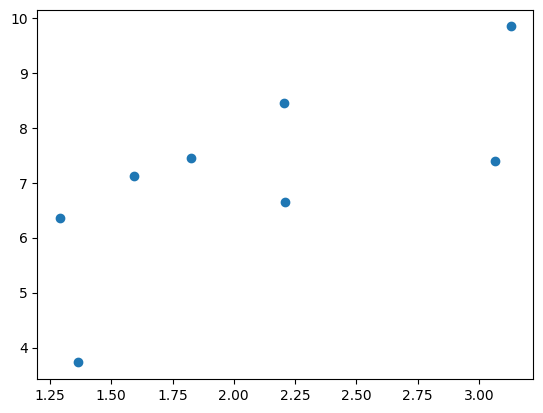

In [127]:
# 来看看产生x-y分布是什么样的
x, y = get_fake_data()
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())

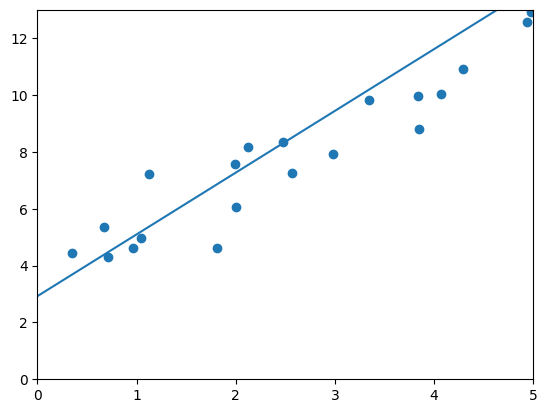

2.026895761489868 2.9732823371887207


In [128]:
# 随机初始化参数
w = t.rand(1, 1, requires_grad=True)
b = t.zeros(1, 1, requires_grad=True)
losses = np.zeros(500)

lr = 0.005  # 学习率

for ii in range(500):
    x, y = get_fake_data(batch_size=32)

    # forward: 计算loss
    y_pred = x.mm(w) + b.expand_as(y)
    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()
    losses[ii] = loss.item()

    # backward: 自动计算梯度
    loss.backward()

    # 更新参数
    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)

    # 梯度清零
    w.grad.data.zero_()
    b.grad.data.zero_()

    if ii % 50 == 0:
        # 画图
        display.clear_output(wait=True)
        x = t.arange(0, 6).float().view(-1, 1)
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy())  # predicted

        x2, y2 = get_fake_data(batch_size=20)
        plt.scatter(x2.numpy(), y2.numpy())  # true data

        plt.xlim(0, 5)
        plt.ylim(0, 13)
        plt.show()
        plt.pause(0.5)

print(w.item(), b.item())

(5.0, 50.0)

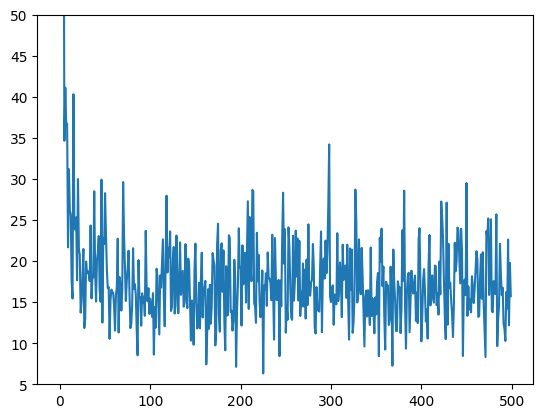

In [129]:
plt.plot(losses)
plt.ylim(5, 50)

用 autograd 实现的线性回归最大的不同点就在于 autograd 不需要计算反向传播, 可以自动计算微分. 这点不单是在深度学习, 在许多机器学习的问题中都很有用. 另外需要注意的是在每次反向传播之前要记得先把梯度清零.

## 本章小结

本章主要介绍了 PyTorch 中的基础底层的数据结构 Tensor 和 autograd 方法. Tensor 是一个类似 Numpy 数组的高效多维数值运算数据结构, 有着和 Numpy 相类似的接口, 并提供简单易用的 GPU 加速. `autograd` 是 PyTorch 的自动微分引擎, 采用动态计算图技术, 能够快速高效的计算导数.